In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('AlphaOri_AAVSO_ATEL.csv')

In [3]:
data

,Unnamed: 0,time,Vmag,Verr
0,0,1983.164659,0.577,0.024
1,1,1983.186769,0.604,0.033
2,2,1984.229878,0.644,0.011
3,3,1986.992113,0.500,0.003
4,4,1987.065951,0.478,0.005
...,...,...,...,...
1577,1577,2020.310934,0.456,0.010
1578,1578,2020.478142,0.660,0.015
1579,1579,2020.530055,0.760,0.015
1580,1580,2020.549180,0.800,0.015


In [4]:
data['time']

0       1983.164659
1       1983.186769
2       1984.229878
3       1986.992113
4       1987.065951
           ...     
1577    2020.310934
1578    2020.478142
1579    2020.530055
1580    2020.549180
1581    2020.555724
Name: time, Length: 1582, dtype: float64

[Text(0, 0.5, 'V [mag]'), Text(0.5, 0, 'Time[years]')]

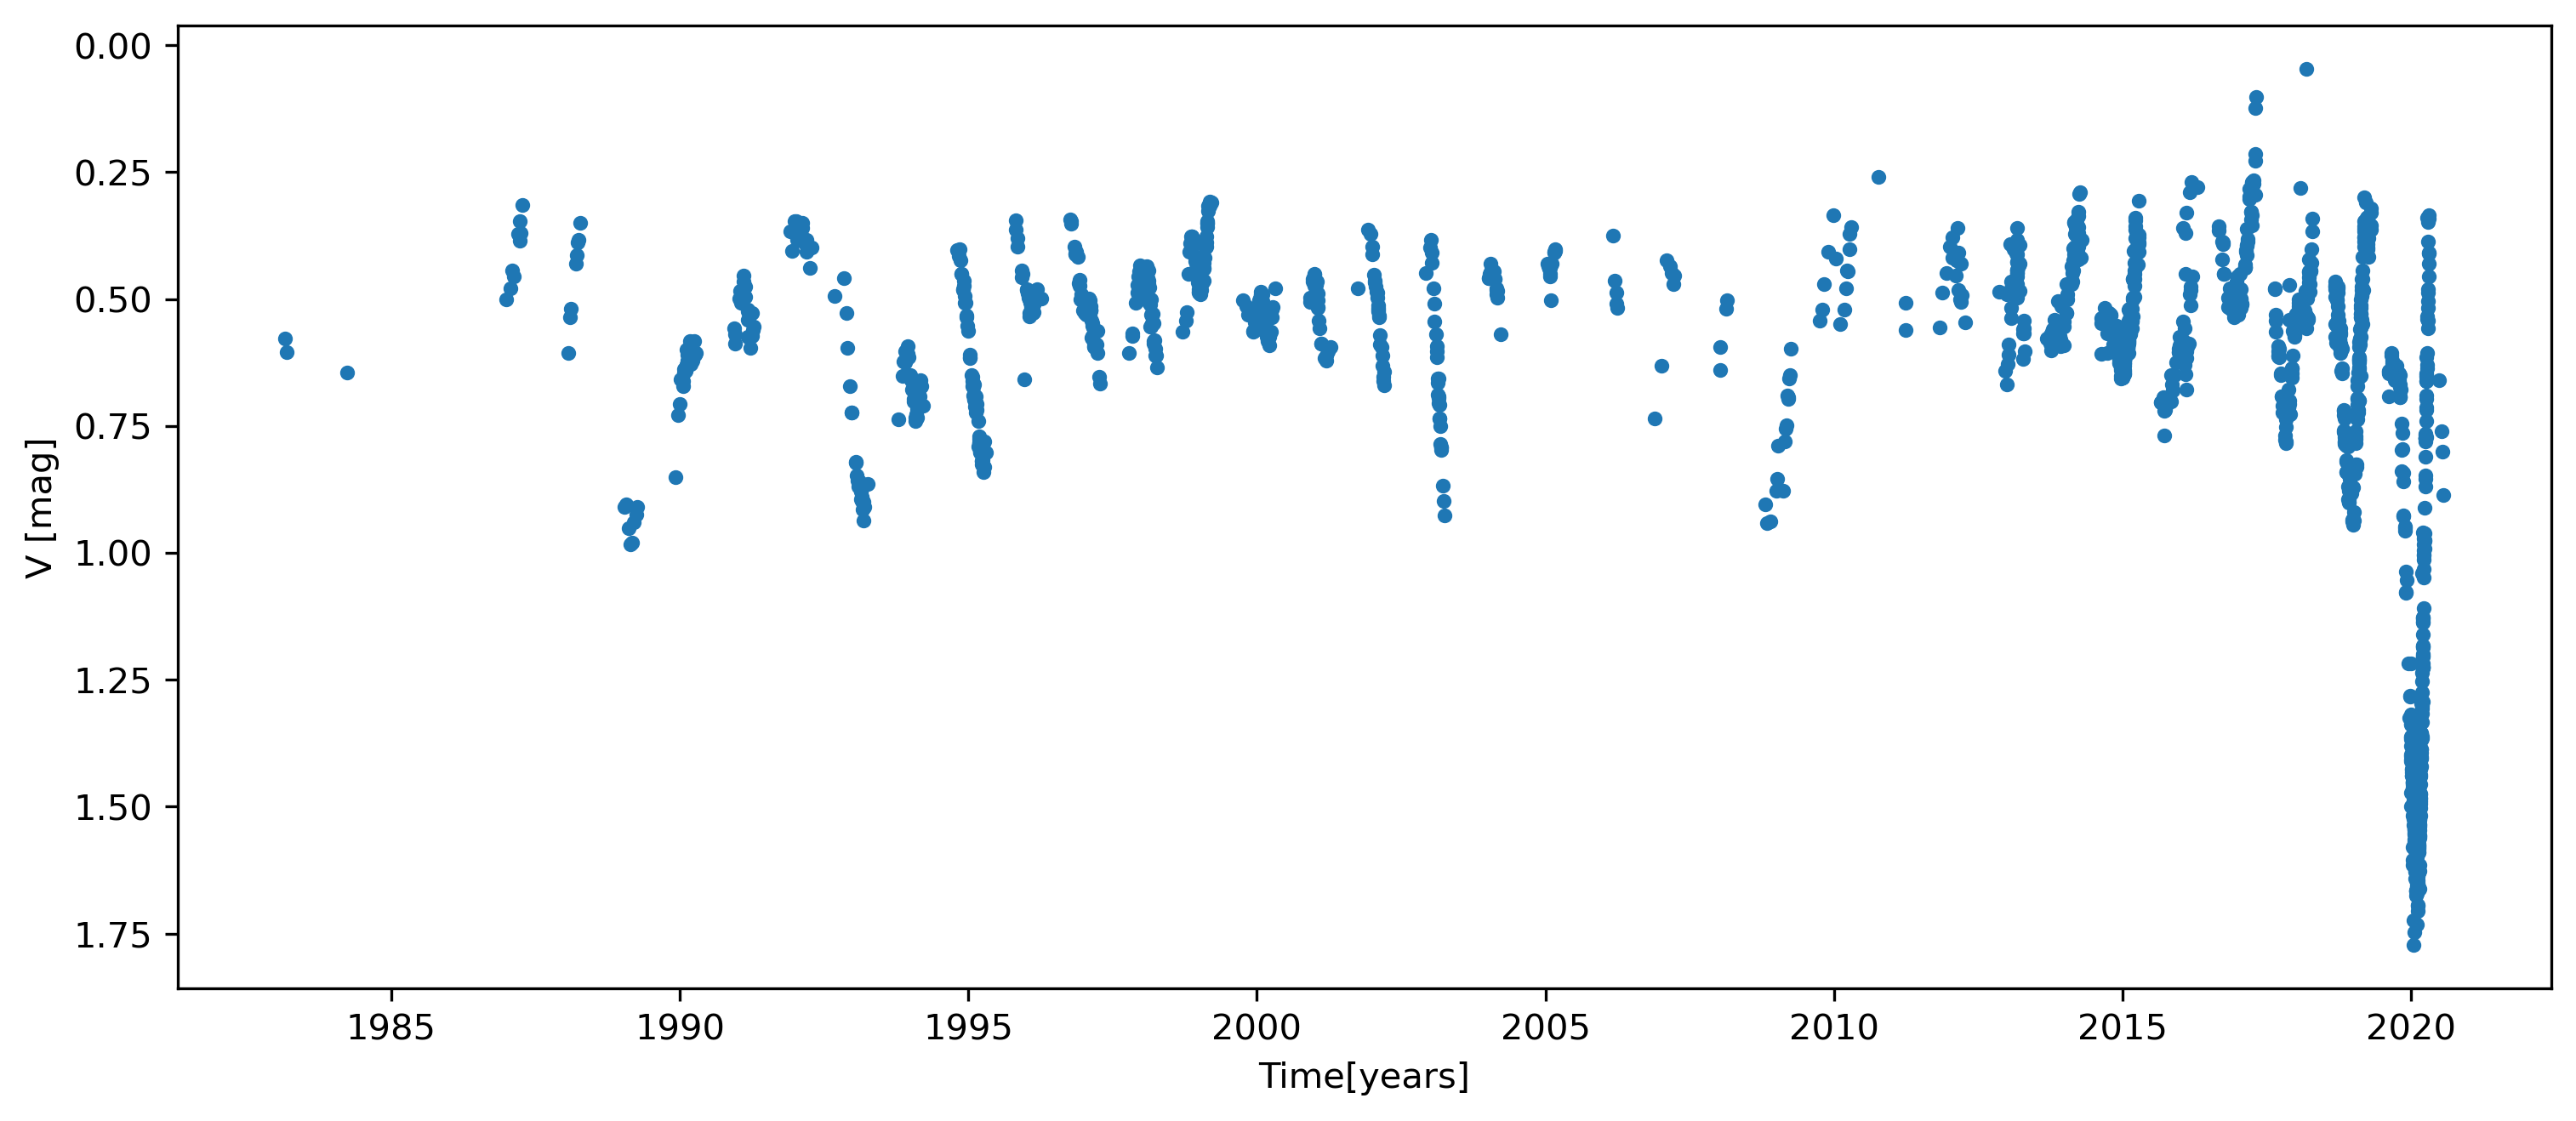

In [5]:
fig, ax = plt.subplots(figsize=(12,5), dpi=300)

plt.scatter(data['time'],data['Vmag'], s=10)
plt.gca().invert_yaxis()

ax.set(xlabel='Time[years]', ylabel='V [mag]')

In [6]:
from astropy.timeseries import LombScargle

time = data['time'].values
mag = data['Vmag'].values
err = data['Verr'].values

nodip = time < 2019.5
time = time[nodip]
mag = mag[nodip]
err = err[nodip]
print(nodip)

ls = LombScargle(time, mag) # dy=err

freq, power =ls.autopower()

[ True  True  True ... False False False]


[Text(0, 0.5, 'Power'),
 (0.0, 10.0),
 Text(0.5, 0, 'Frequency[yr$^{-1}$]'),
 Text(0.5, 1.0, 'Periodogram')]

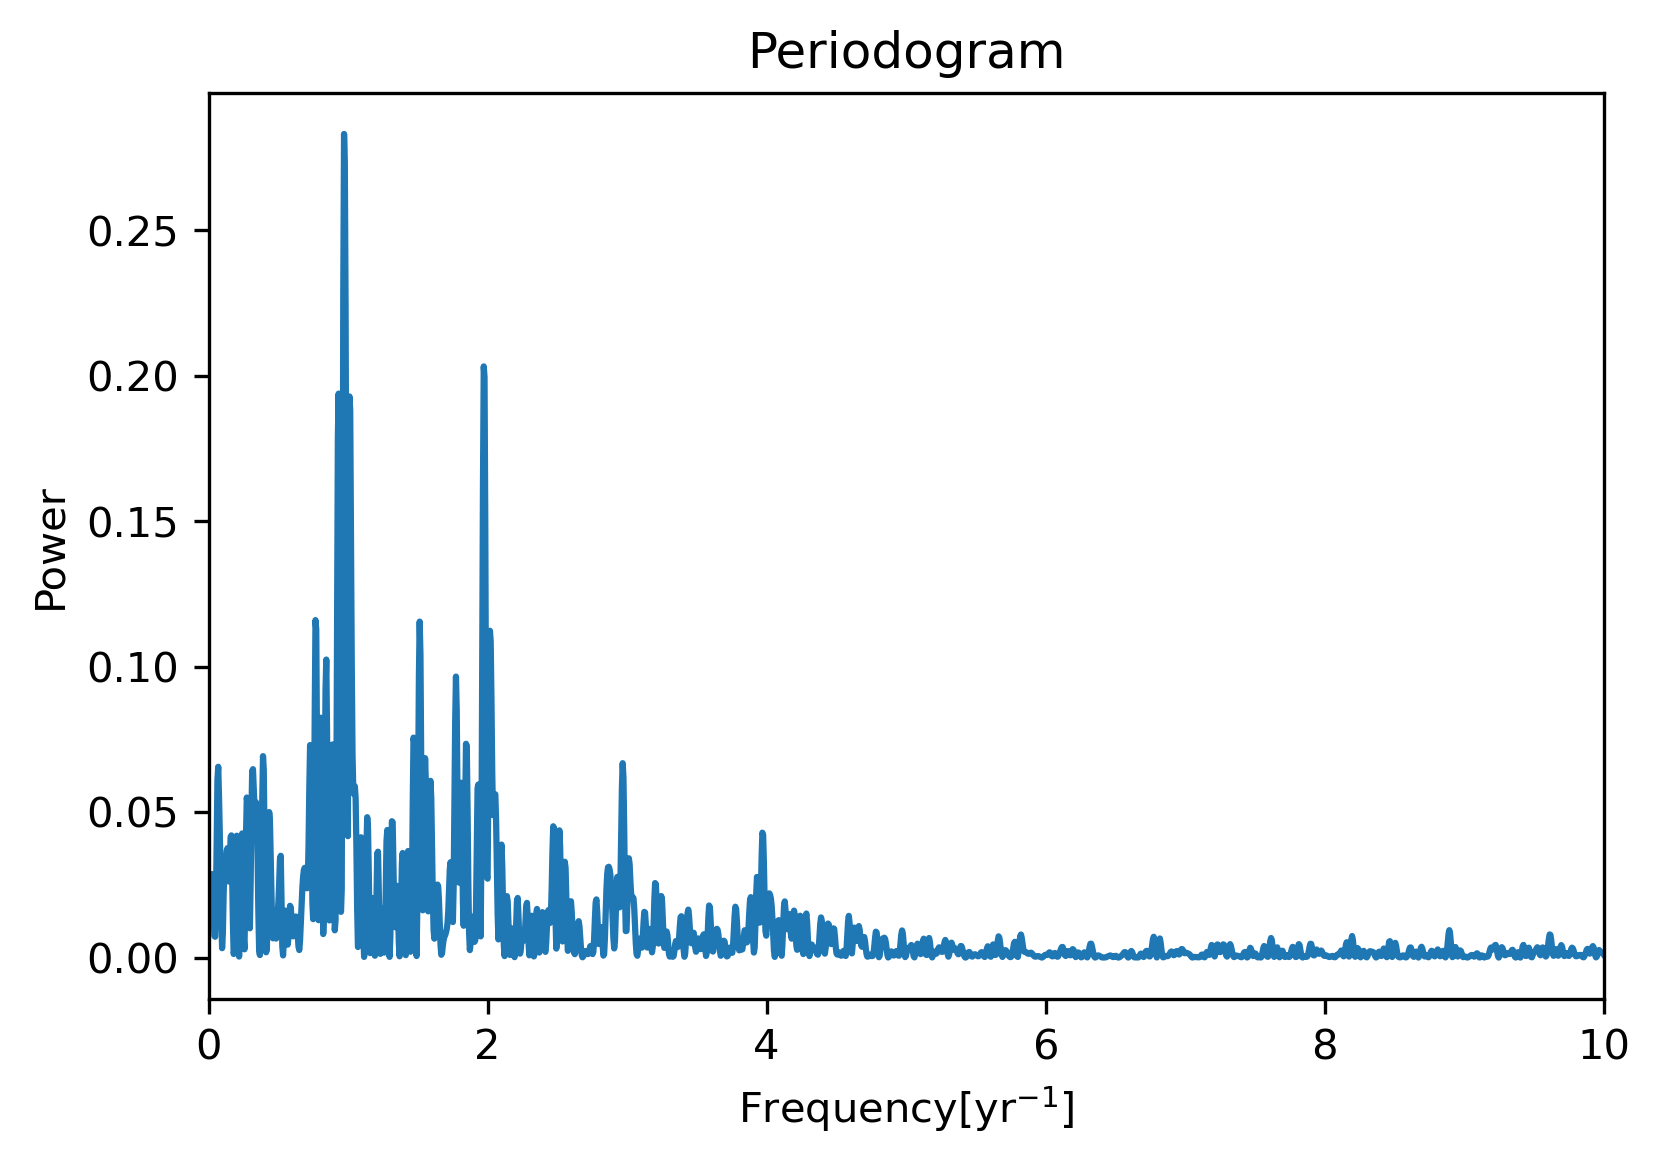

In [7]:
fig, ax = plt.subplots(dpi=300)

ax.plot(freq, power)
ax.set(xlabel='Frequency[yr$^{-1}$]', ylabel='Power',title= 'Periodogram', xlim=(0,10))

In [8]:
freq[np.argmax(power)]

0.9710322690360349

In [9]:
def rednoise(frequency, alpha0, tau, gamma, alphaw):

    return (alpha0/((1+(2*np.pi*tau*frequency))**gamma)) + alphaw


[Text(0, 0.5, 'Power'),
 Text(0.5, 0, 'Period[Days]'),
 Text(0.5, 1.0, 'Periodogram')]

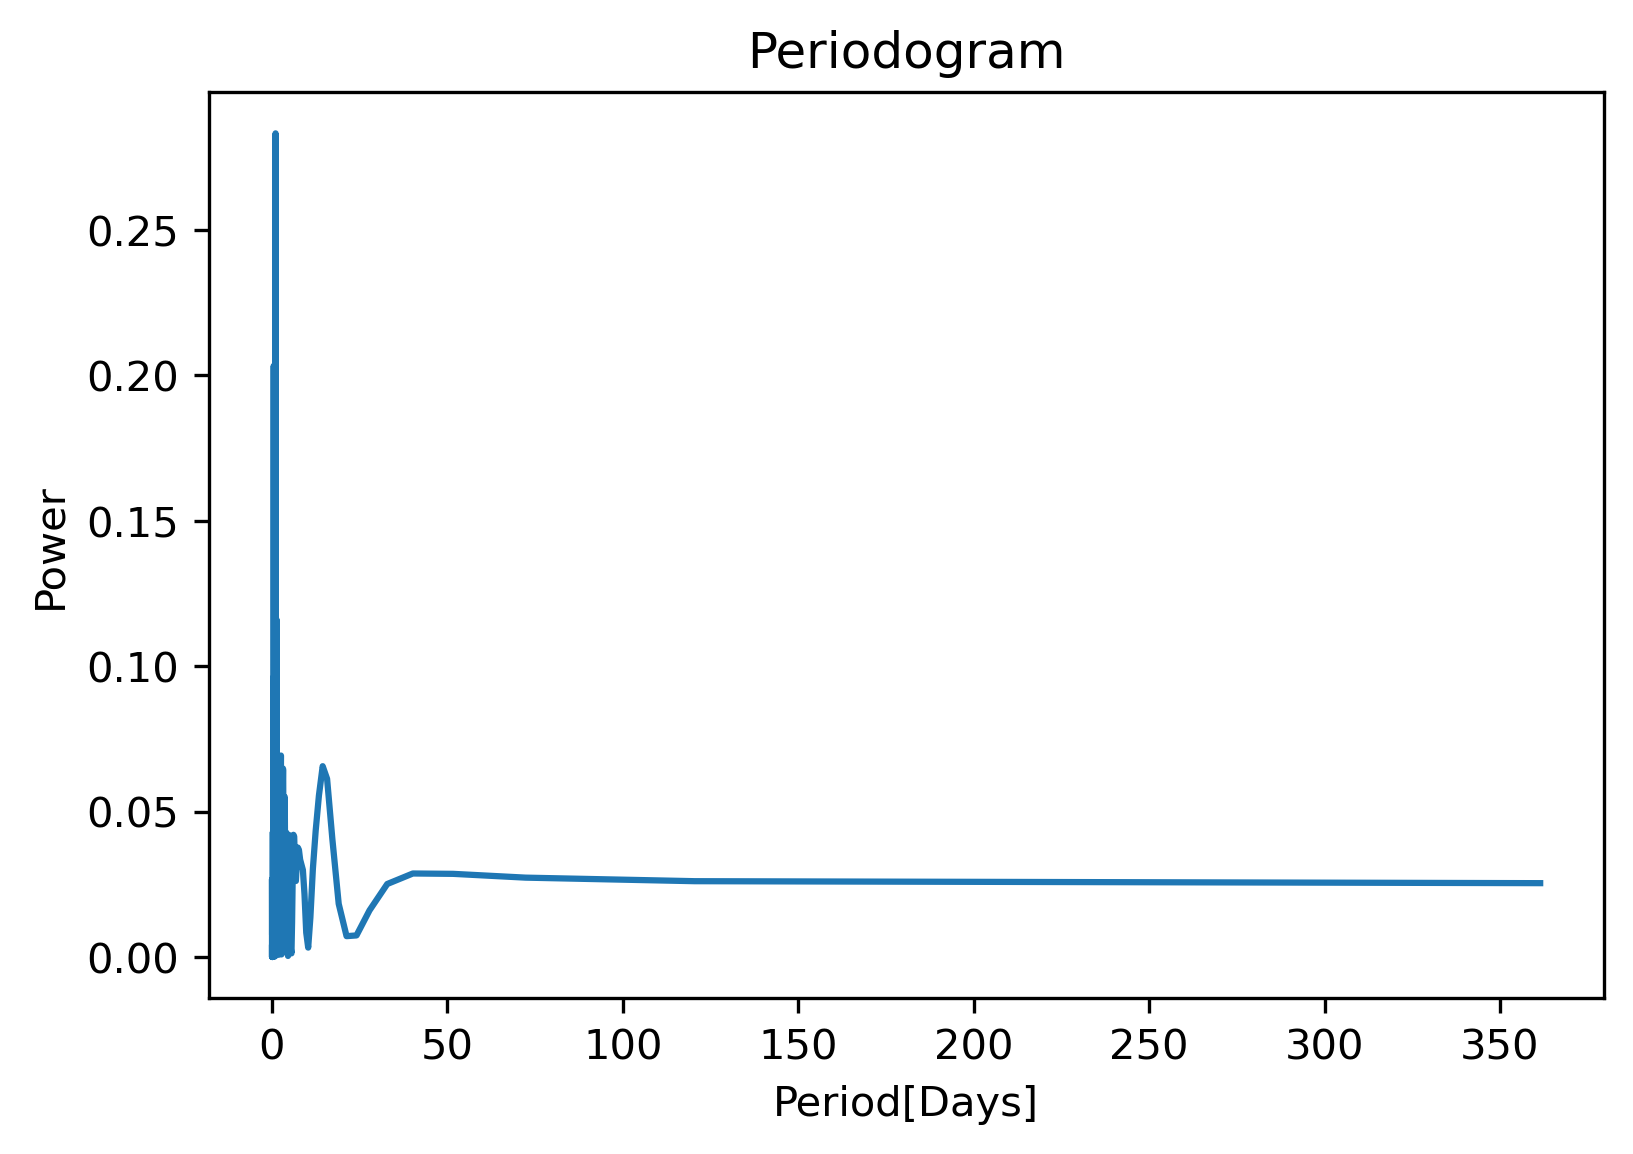

In [10]:
fig, ax = plt.subplots(dpi=300)

ax.plot(1/freq, power)
ax.set(xlabel='Period[Days]', ylabel='Power',title= 'Periodogram',)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


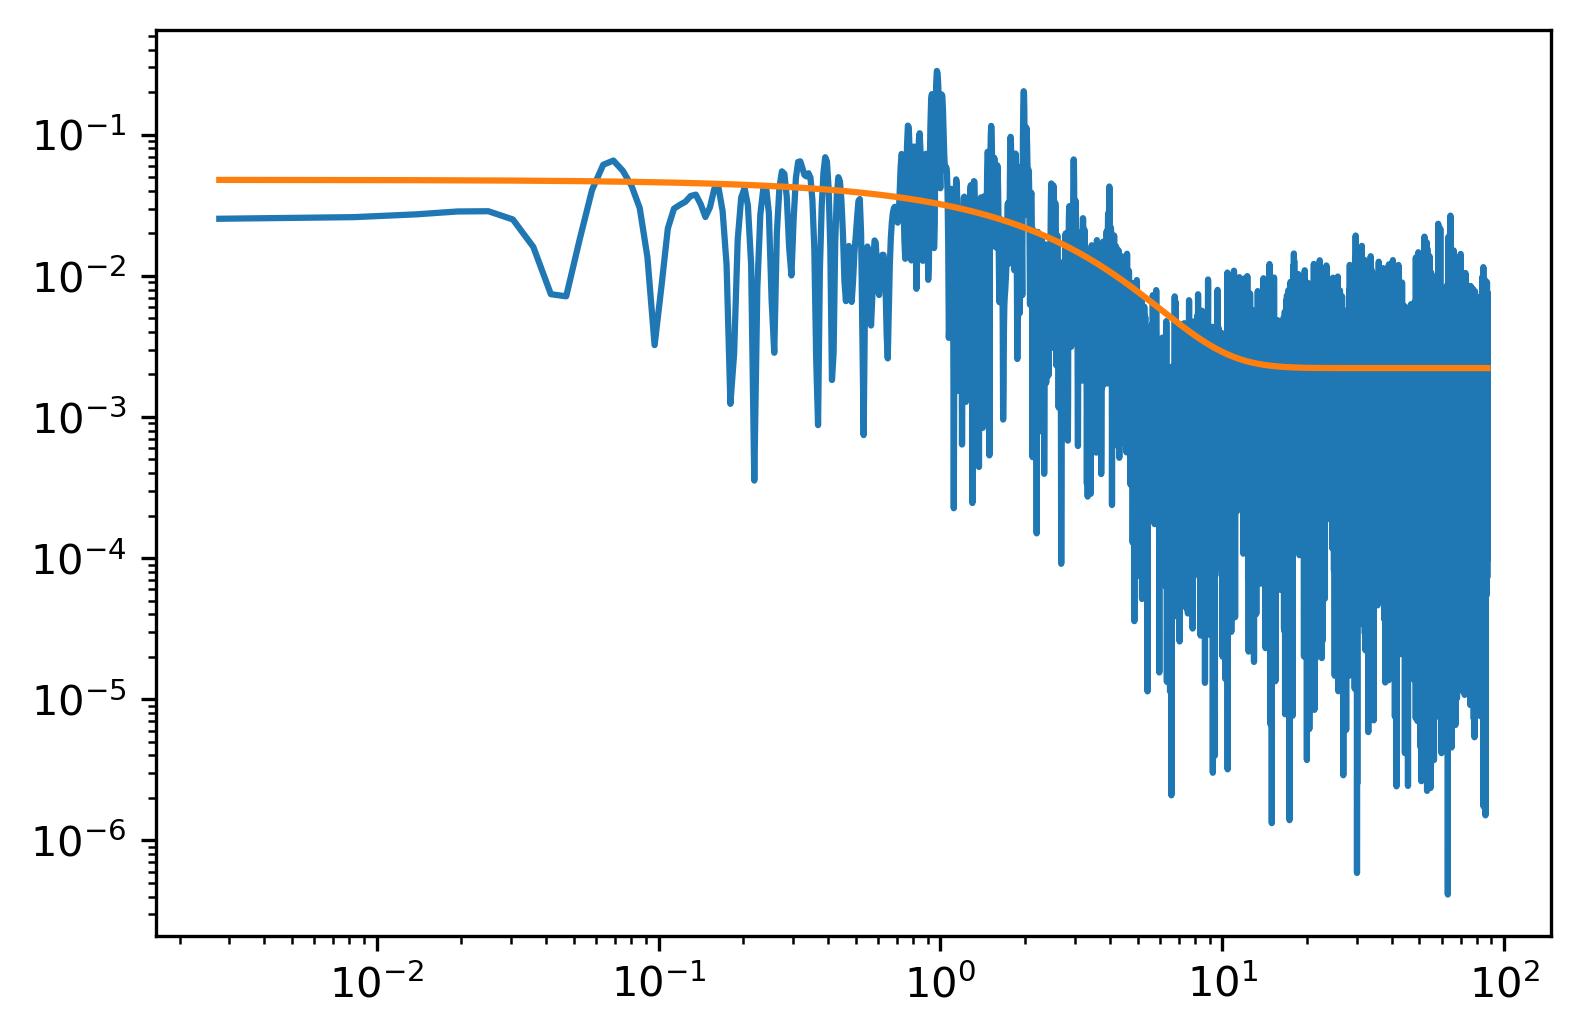

In [13]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(rednoise, freq, power, p0 = (0.05, 0.1, 2, 0.01))

fig = plt.figure(dpi=300)
plt.plot(freq, power)
plt.plot(freq,rednoise(freq, *popt))
plt.xscale('log')
plt.yscale('log')

[None,
 Text(0, 0.5, 'Power'),
 None,
 Text(0.5, 0, 'Frequency[yr$^{-1}$]'),
 Text(0.5, 1.0, 'Periodogram')]

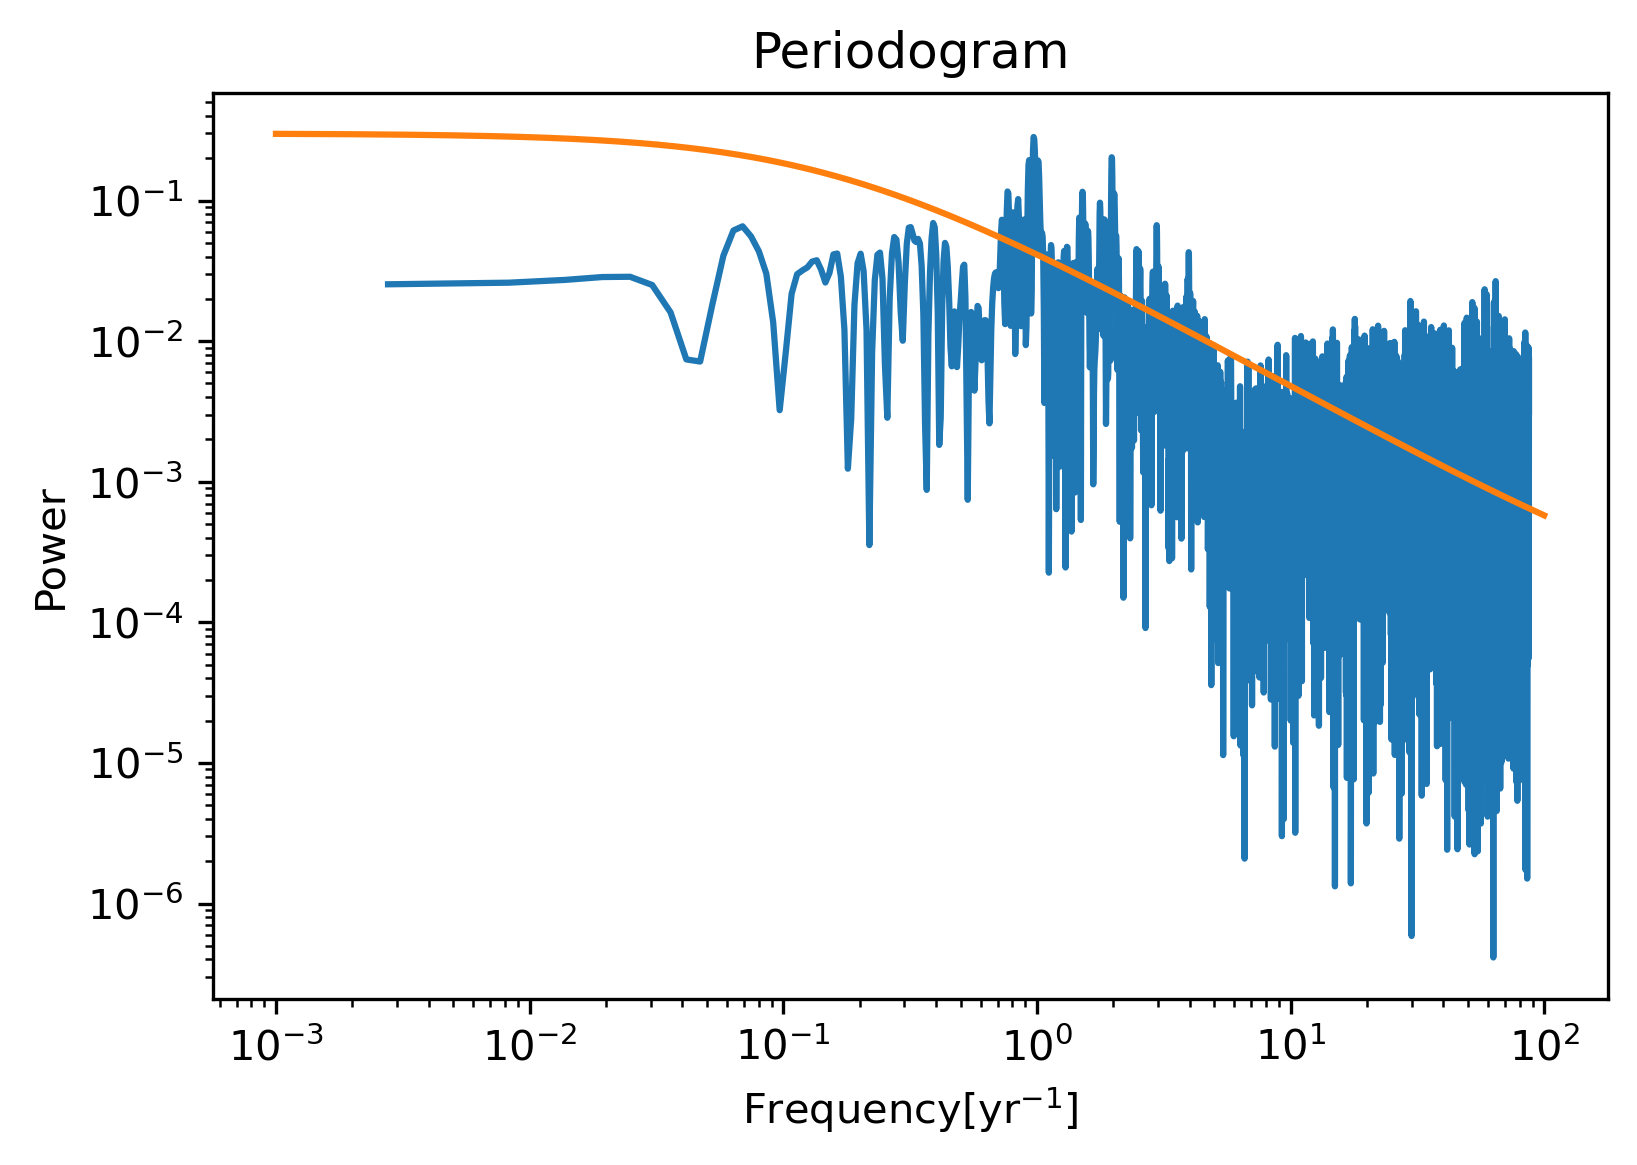

In [13]:
fig, ax = plt.subplots(dpi=300)

ax.plot(freq, power)
ax.plot(test_frequencies, test_power)

ax.set(xlabel='Frequency[yr$^{-1}$]', ylabel='Power',title= 'Periodogram', xscale= 'log', yscale='log')

[None,
 Text(0, 0.5, 'Power'),
 None,
 Text(0.5, 0, 'Period[Days]'),
 Text(0.5, 1.0, 'Periodogram')]

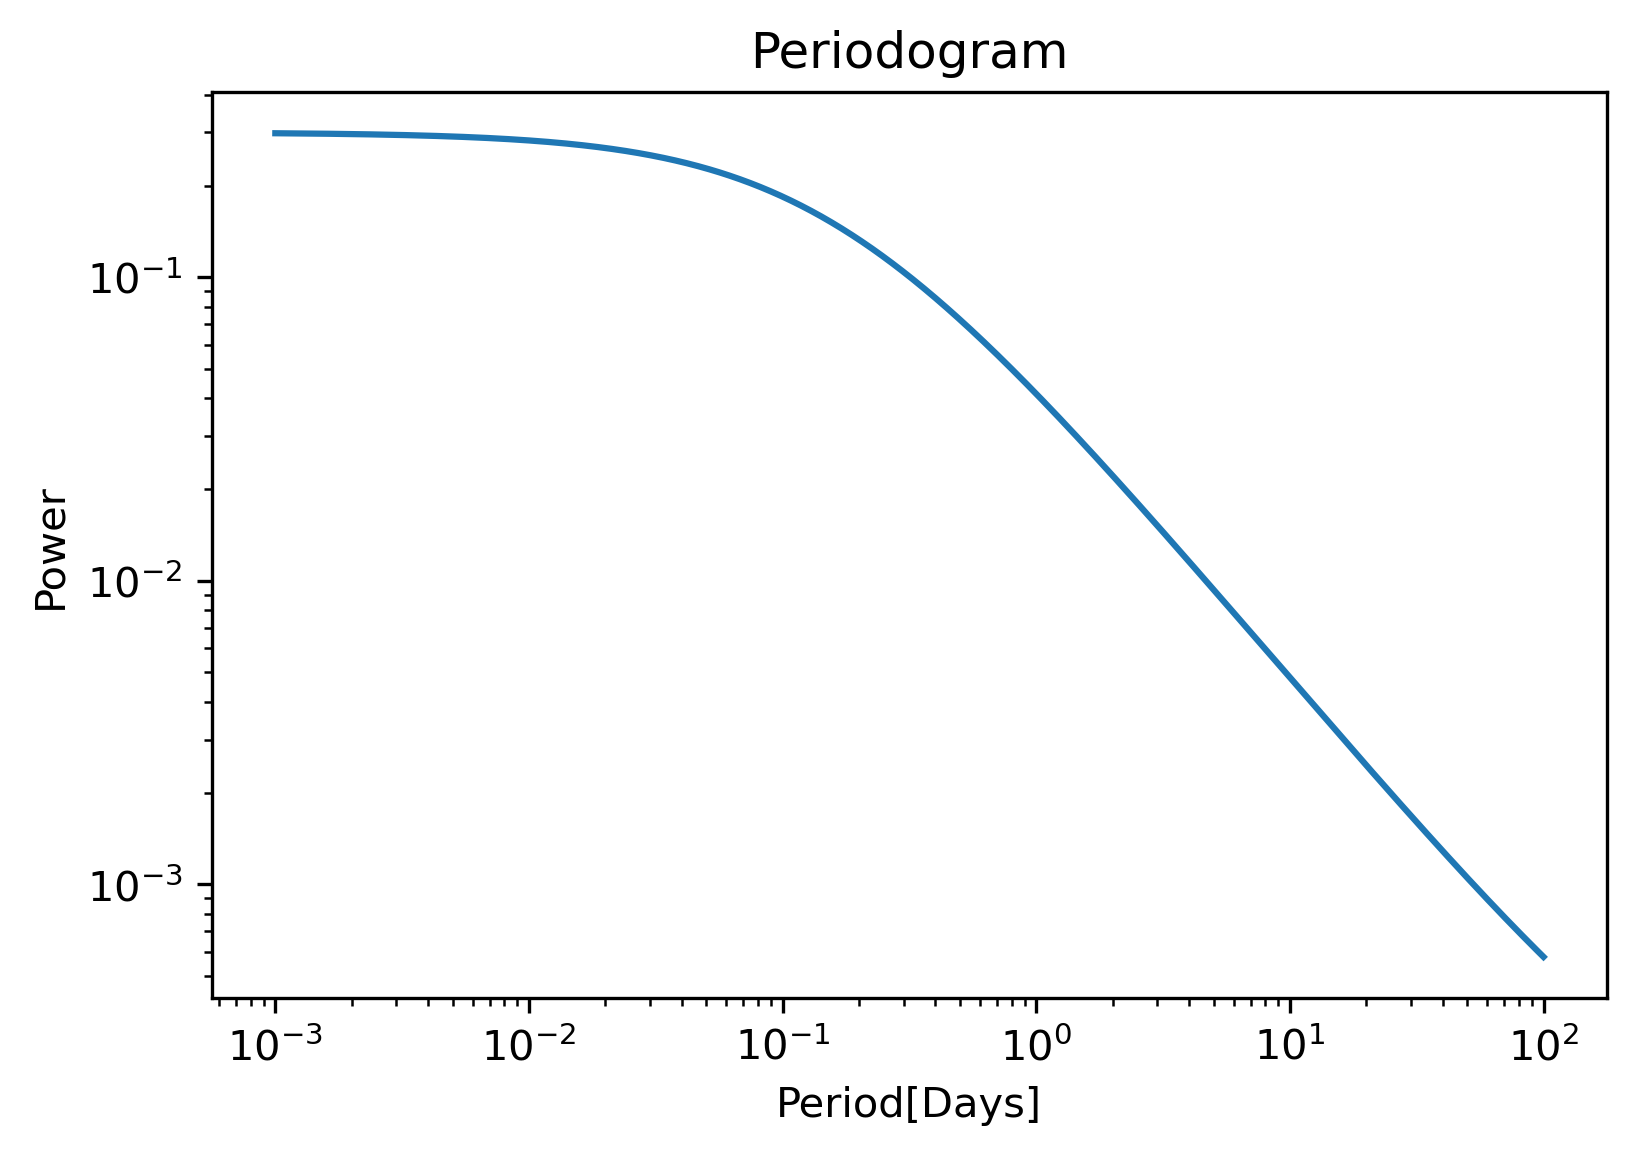

In [12]:
test_frequencies = np.logspace(-3, 2, 1000)
test_power = rednoise(test_frequencies, 0.3, 1, 1, 1e-4)

fig, ax = plt.subplots(dpi=300)

ax.plot(test_frequencies,test_power)
ax.set(xlabel='Period[Days]', ylabel='Power',title= 'Periodogram', xscale ='log', yscale = 'log')


In [14]:
from astropy.timeseries import LombScargle
ls = LombScargle(time, mag)
freq, power =ls.autopower()

In [15]:
def rednoise(frequency, alpha0, tau, gamma, alphaw):
    num = alpha0
    den = 1.0 + (2*np.pi*tau*frequency)**gamma
    return num/den + alphaw

In [16]:
def log_rednoise(frequency, alpha0, tau, gamma, alphaw):
    return np.log10(rednoise(frequency, alpha0, tau, gamma, alphaw))


In [20]:
from scipy.optimize import curve_fit

In [21]:
def fit_rednoise(time, mag):
    # Input: time and magnitude arrays
    
    # Step 1: Calculate the Lomb-Scargle Periodogram

    ls = LombScargle(time, mag)
    freq, power =ls.autopower()
    
    # Step 1.5: Calculate the log of the lomb-scargle periodogram
    log_power = np.log10(power) 
    
    # Step 2: Curve fit red noise function
    popt,pcov = curve_fit(log_rednoise, freq, log_power, p0 = (0.05, 0.1, 2, 0.01))
    
    alpha0, tau, gamma, alphaw = popt
   
    return alpha0, tau, gamma, alphaw


In [25]:
fit_rednoise(time, mag)
Arg = fit_rednoise(time, mag)
Arg

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


(0.017356585489036423,
 0.05332044275624999,
 6.237742606432449,
 0.001325168019962812)

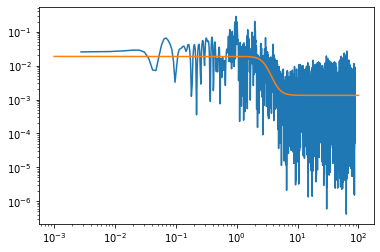

In [27]:
fs = np.logspace(-3,2,1000)
p = rednoise(fs,*Arg)
plt.plot(freq, power)
plt.plot(fs,p)
plt.xscale('log')
plt.yscale('log')





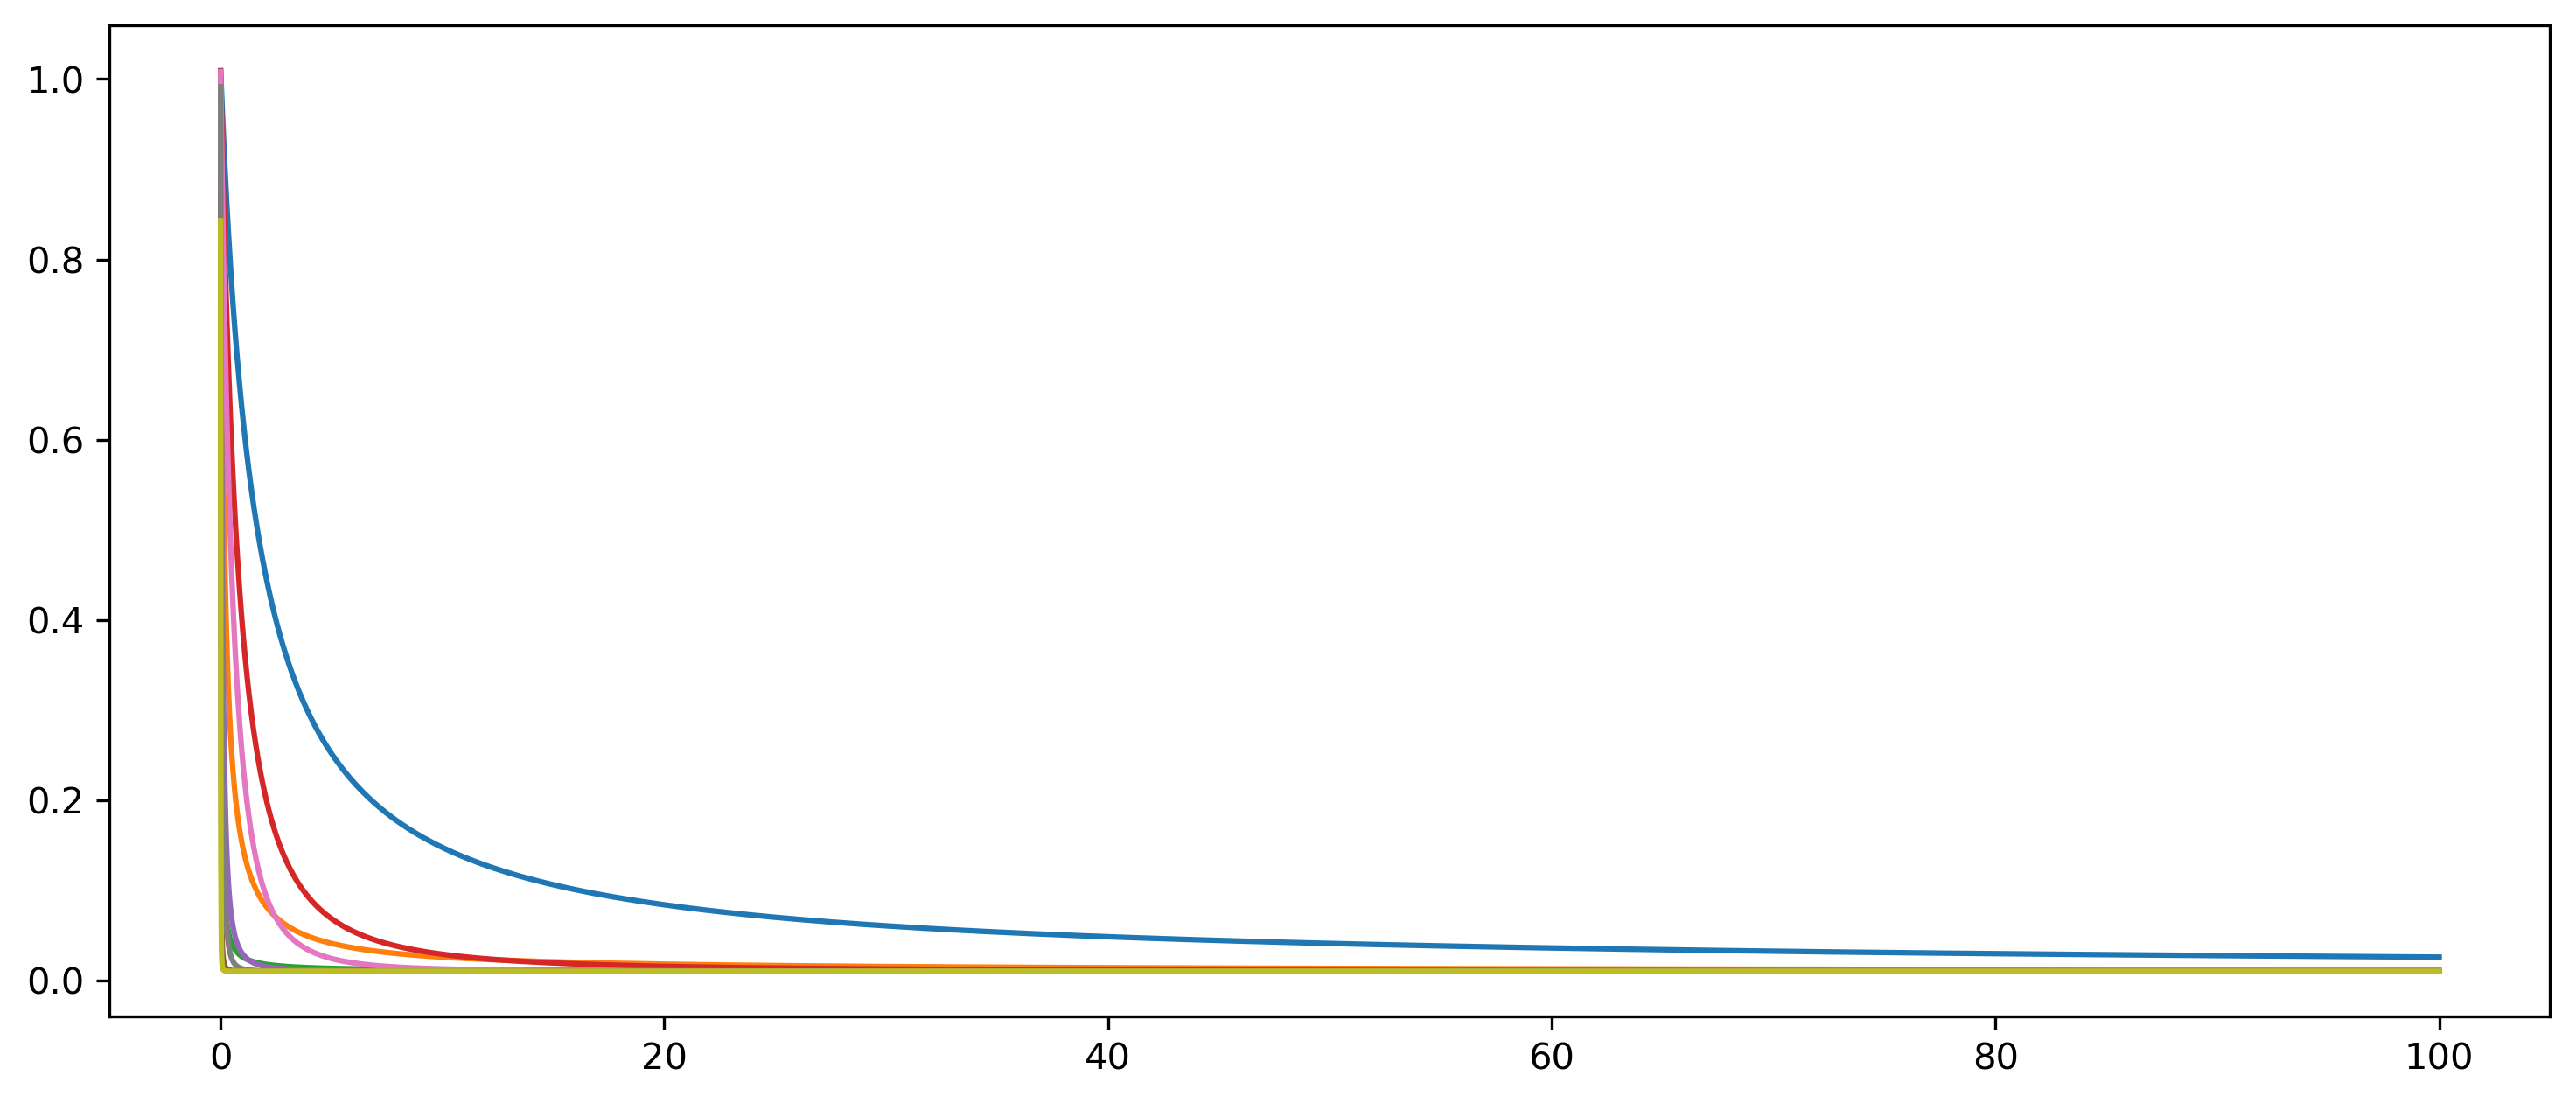

In [24]:
fig, ax = plt.subplots(figsize=(12,5), dpi=300)

gammas = [1,2,3]
tau = [0.1, 1, 10]
for g in gammas:
    for t in tau:
        test_power = rednoise(test_frequencies, 1, t, g, 1e-2)
        ax.plot(test_frequencies, test_power, label=fr'$\tau={t},\gamma={g}$')